In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import h5py
from pickle import dump

In [3]:
def plot_learningCurve(history, epochs):
    
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()


In [4]:
datadir = 'MQTT Data'                                                          #Dataset Folder
columns = ['x', 'y', 'z','Gyx','Gyy','Gyz']

fulllist = []                                                                  #Empty list to hold data
lab = []                                                                       #Empty list to hold labels

datadirs = os.listdir(datadir)                                                 #List class folders

label_count = 0

for classdir in datadirs:
    files = os.listdir(os.path.join(datadir,classdir))
    for file in files:
        data = pd.read_csv(os.path.join(datadir,classdir,file), names = columns)  #Read ecah CSV file
        data = data.values                                                        #Convert to list of values
        label_count += (len(data))
        fulllist.extend(data)                                                     #Add data to datalist
    lab.extend([int(classdir)]*label_count)                                       #Add labels to label list
    label_count = 0
       
    
scaler = MinMaxScaler()                                                           
X = scaler.fit_transform(fulllist)                                                #Scale dataset
scaled_X = pd.DataFrame(data = X, columns = columns)
dump(scaler, open('scaler.pkl', 'wb'))                                            #Save scaler values to pickle file

print('Length of dataset: ', str(scaled_X.shape[0]))
print(scaled_X.head()) 



Length of dataset:  876000
          x         y         z       Gyx       Gyy       Gyz
0  0.483444  0.544776  0.532995  0.439835  0.440542  0.535839
1  0.582781  0.485075  0.451777  0.514857  0.494061  0.511042
2  0.682119  0.671642  0.659898  0.510003  0.446482  0.464549
3  0.615894  0.544776  0.558376  0.446602  0.467463  0.491670
4  0.562914  0.522388  0.446701  0.465725  0.436992  0.505231


In [5]:

frame_size = 100
hop_size = 20


def get_frames(df,frame_size,hop_size,lab):

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        frame = df.values[i: i + frame_size]
        label = stats.mode(lab[i: i + frame_size])[0][0]
        frames.append(frame)
        labels.append(label)



    frames = np.asarray(frames)
    labels = np.asarray(labels)

    return frames, labels


X, y = get_frames(scaled_X, frame_size, hop_size, lab)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)


(43795, 100, 6) (43795,)


Epoch 1/12
1095/1095 [==============================] - 43s 39ms/step - loss: 1.1592 - accuracy: 0.4696 - val_loss: 0.6088 - val_accuracy: 0.7536
Epoch 2/12
1095/1095 [==============================] - 47s 43ms/step - loss: 0.4804 - accuracy: 0.8071 - val_loss: 0.2036 - val_accuracy: 0.9253
Epoch 3/12
1095/1095 [==============================] - 51s 47ms/step - loss: 0.2800 - accuracy: 0.8951 - val_loss: 0.2026 - val_accuracy: 0.9231
Epoch 4/12
1095/1095 [==============================] - 53s 49ms/step - loss: 0.2226 - accuracy: 0.9184 - val_loss: 0.1239 - val_accuracy: 0.9525
Epoch 5/12
1095/1095 [==============================] - 52s 47ms/step - loss: 0.1811 - accuracy: 0.9345 - val_loss: 0.1460 - val_accuracy: 0.9441
Epoch 6/12
1095/1095 [==============================] - 51s 47ms/step - loss: 0.1558 - accuracy: 0.9429 - val_loss: 0.0803 - val_accuracy: 0.9700
Epoch 7/12
1095/1095 [==============================] - 52s 48ms/step - loss: 0.1456 - accuracy: 0.9484 - val_loss: 0.1131 -

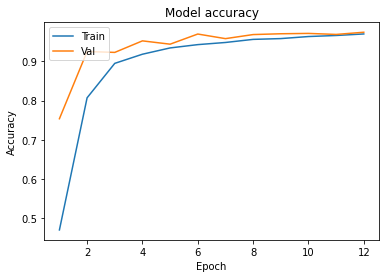

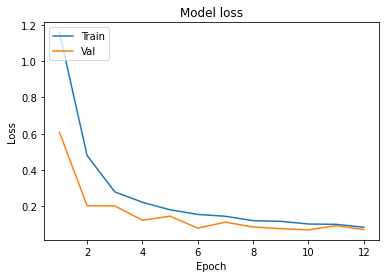

In [11]:
epochs = 12


model = Sequential([Conv2D(16, (3,3),  activation = 'relu',padding="same", input_shape = X_train[0].shape),
                    Dropout(0.1),
                    Conv2D(32, (2,2),  activation = 'relu'),
                    Conv2D(64, (2,2),  activation = 'relu'),
                    Conv2D(128, (2,2),  activation = 'relu'),
                    Dropout(0.2),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dropout(0.5),
                    Dense(4, activation = 'softmax')])
 
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

history = model.fit(X_train, y_train, epochs = epochs, validation_data =(X_test,y_test), verbose = 1)

plot_learningCurve(history, epochs)
model.save("model_ex.h5")

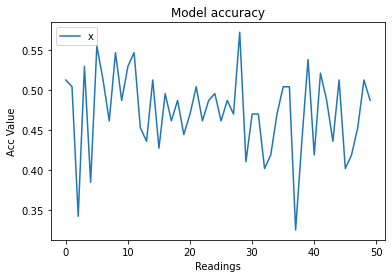

In [92]:
num_points = 50

values = Test_scaled_X['x'][:num_points]
plt.plot(range(len(values)), Test_scaled_X['x'][:num_points])
# plt.plot(range(len(values)), Test_scaled_X['y'][:num_points])
# plt.plot(range(len(values)), Test_scaled_X['z'][:num_points])
plt.title('Model accuracy')
plt.ylabel('Acc Value')
plt.xlabel('Readings')
plt.legend(['x', 'y','z'], loc='upper left')
plt.show()
